# Лабораторная работа №3
Выполнила Фонград Анастасия КИ21-16/1б

In [167]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lars, TweedieRegressor, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import warnings
from math import log
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import t
from itertools import product
import seaborn as sns

In [168]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [169]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

## Предварительная обработка данных

In [170]:
ids = test_data["id"]
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
answer = 'Цена'

In [171]:
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,50.781176,4.894802,8.935644,0.142327,0.101485,0.024752,0.101485,0.772277,...,10.372525,4.674505,0.143564,7.788366,2.501238,13.263614,4.149752,6.754950,13.470297,2.699083e+06
std,0.996109,0.198046,19.827507,3.760826,4.754526,0.349601,0.302157,0.155466,0.302157,0.419622,...,15.397133,3.255991,0.378064,8.983450,1.636025,7.557860,5.955523,6.873569,8.068579,1.096460e+06
min,1.000000,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,37.650000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,0.000000,3.000000,1.000000,8.000000,1.000000,2.000000,7.000000,1.950000e+06
50%,2.000000,0.000000,48.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,4.000000,0.000000,6.000000,2.000000,13.000000,3.000000,5.000000,12.000000,2.550000e+06
75%,3.000000,0.000000,63.075000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.000000,7.000000,0.000000,9.000000,4.000000,18.000000,5.000000,10.000000,19.000000,3.310000e+06
max,5.000000,1.000000,120.000000,24.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,86.000000,14.000000,2.000000,67.000000,8.000000,42.000000,52.000000,40.000000,40.000000,6.800000e+06


Можно увидеть, что категориальные признаки уже были закодированы. Для избежания ловушки фиктивных переменных были удалены некоторые колонки

In [172]:
train_data.drop("Без.ремонта", axis=1, inplace=True)
train_data.drop("Совмещенный.санузел", axis=1, inplace=True)
train_data.drop("Смешанные.стены", axis=1, inplace=True)
train_data.drop("Иные.перекрытия", axis=1, inplace=True)

Получим список всех числовых признаков. Числовыми будем считать признаки с более чем 5 уникальными значениями

In [173]:
numeric = []
categorical = []
for name in train_data.columns:
    if train_data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
numeric.remove(answer)
columns = numeric + categorical
print("Numeric features:", numeric)
print("Categorical features:", categorical)

Numeric features: ['Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000']
Categorical features: ['Количество.комнат', 'Студия', 'Парковка', 'Дизайнерский', 'Евроремонт', 'Косметический', 'Балкон', 'Лоджия', 'Раздельный.санузел', 'Лифт', 'Грузовой.лифт', 'Мусоропровод', 'Аварийный', 'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Парк.1000', 'Кинотеатр.1000']


Нормализуем числовые признаки

In [174]:
scaler = MinMaxScaler()
train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.fit_transform(test_data[numeric])
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Дизайнерский,Евроремонт,Косметический,Балкон,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,0.370738,0.169339,0.288985,0.142327,0.024752,0.101485,0.772277,0.632426,...,0.120611,0.333893,0.143564,0.116244,0.312655,0.315800,0.079803,0.168874,0.336757,2.699083e+06
std,0.996109,0.198046,0.180250,0.163514,0.198105,0.349601,0.155466,0.302157,0.419622,0.635417,...,0.179036,0.232571,0.378064,0.134081,0.204503,0.179949,0.114529,0.171839,0.201714,1.096460e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,0.251364,0.043478,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.023256,0.142857,0.000000,0.044776,0.125000,0.190476,0.019231,0.050000,0.175000,1.950000e+06
50%,2.000000,0.000000,0.345455,0.130435,0.291667,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.046512,0.285714,0.000000,0.089552,0.250000,0.309524,0.057692,0.125000,0.300000,2.550000e+06
75%,3.000000,0.000000,0.482500,0.217391,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.139535,0.500000,0.000000,0.134328,0.500000,0.428571,0.096154,0.250000,0.475000,3.310000e+06
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.800000e+06


## Отбор информативных признаков
Построим матрицы корреляции признаков

<Axes: >

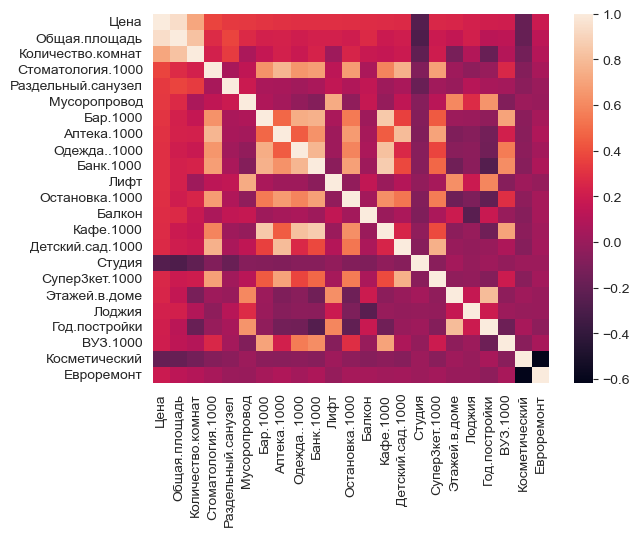

In [175]:
sorted_idx = train_data.corr()[answer].abs().sort_values(ascending=False).index[:23]
corr_matrix = train_data[sorted_idx].corr()
sns.heatmap(corr_matrix)

In [176]:
def show_correlation(names):
    corr_price_df = train_data.corr()[[answer]].transpose()[names]
    sb.heatmap(
    corr_price_df,
    annot=True,
    fmt='.1g',
    vmin=-1,
    vmax=1,
    )
    fig = plt.gcf()
    fig.set_size_inches(35, 5)

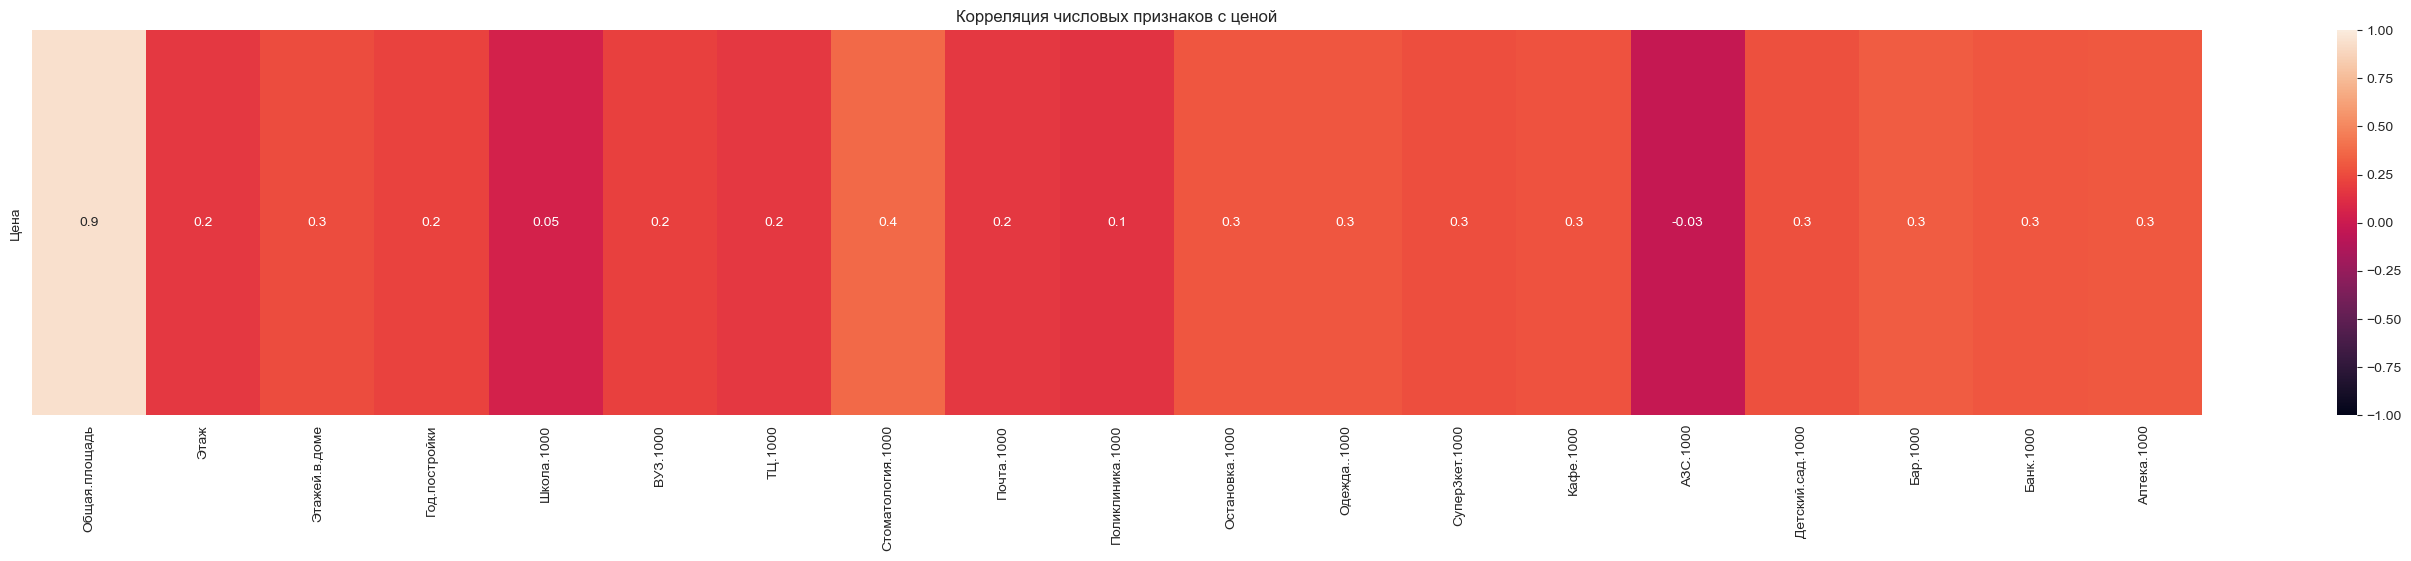

In [177]:
show_correlation(numeric)
plt.title("Корреляция числовых признаков с ценой")
plt.show()

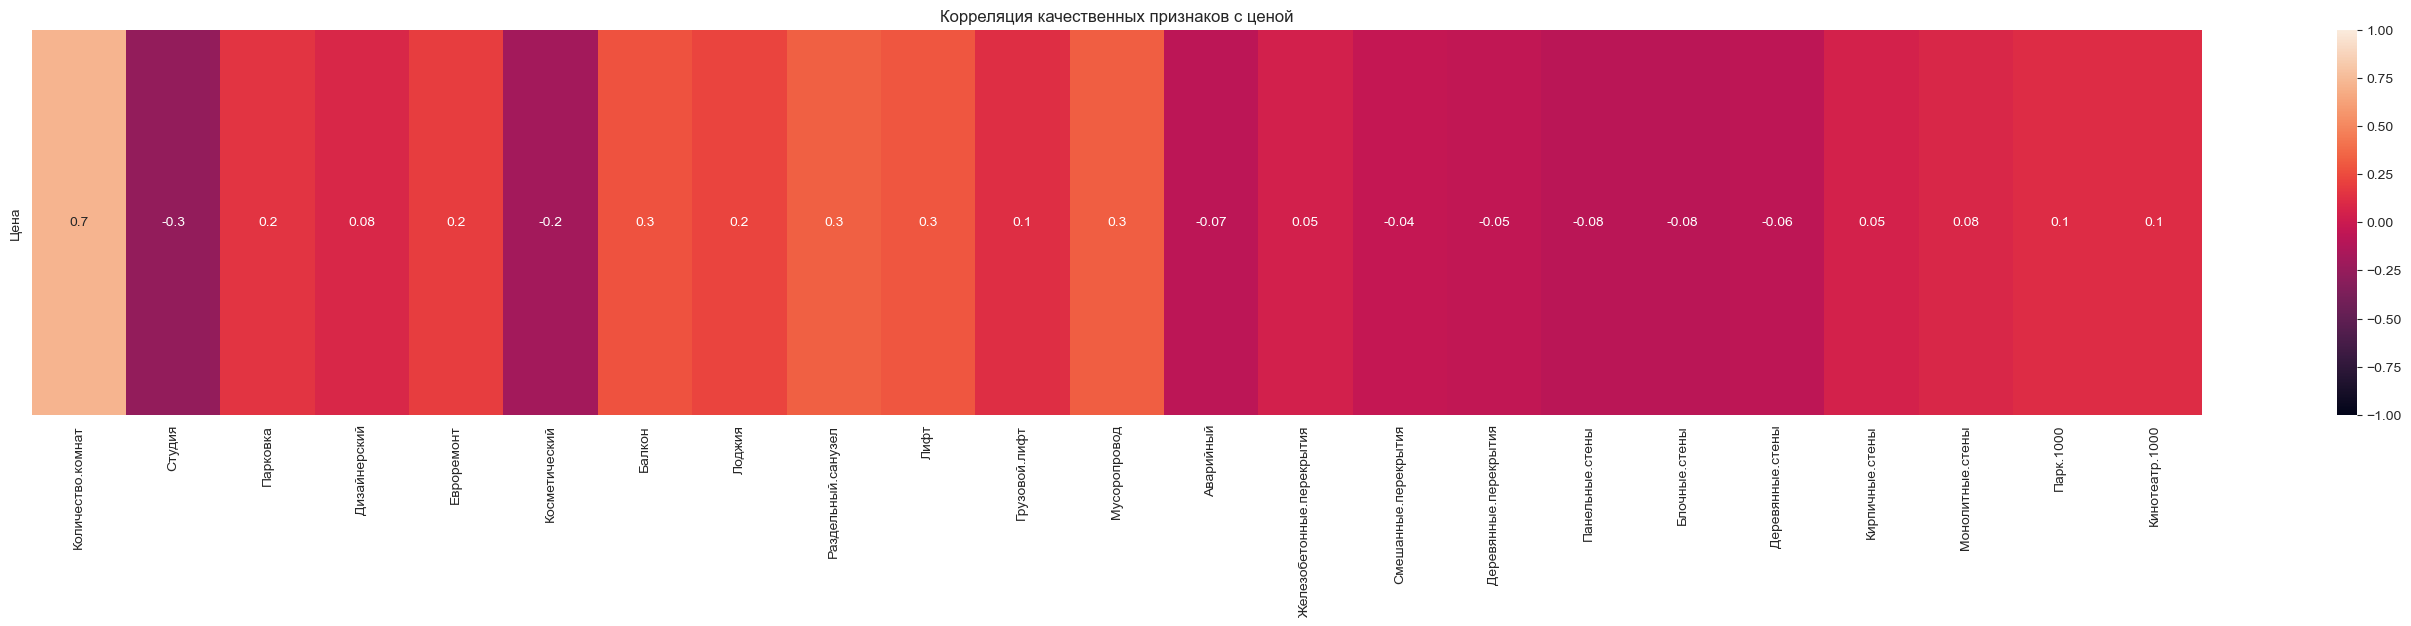

In [178]:
show_correlation(categorical)
plt.title("Корреляция качественных признаков с ценой")
plt.show()

Определим наиболее коррелирующие с ценой признаки

<Axes: >

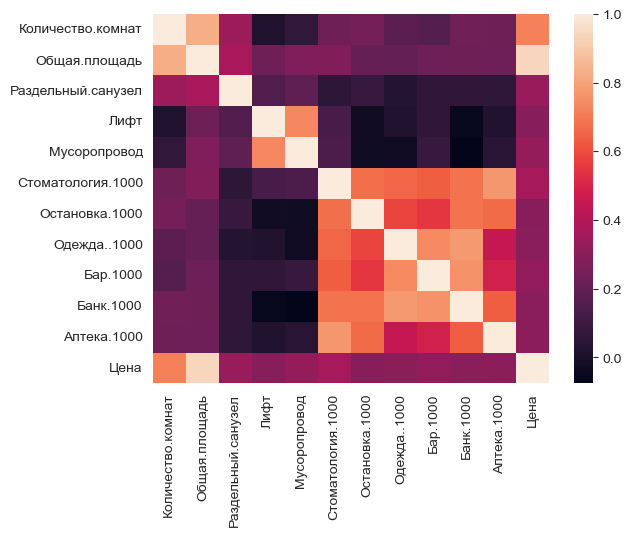

In [179]:
corr_matrix = train_data.corr()
threshold = 0.29
corr_price_matrix = train_data.corrwith(train_data[answer]).abs()
weak_corr_features = set(corr_matrix[corr_price_matrix <= threshold].index)
train_data.drop(weak_corr_features, axis=1, inplace=True)
sns.heatmap(train_data.corr())

Оставим только признаки, меньше всего коррелирующие друг с другом

<Axes: >

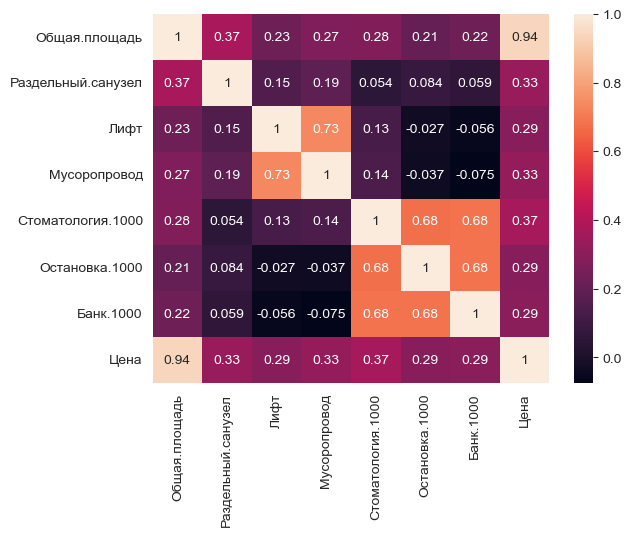

In [180]:
feature_select = train_data.drop(answer, axis=1)
corr_series = feature_select.corr().abs().stack().sort_values()
corr_series = corr_series[~corr_series.duplicated()]
threshold = 0.75
drops = set([feature2 for (feature1, feature2), corr in corr_series.items() if
             corr > threshold and corr != 1])
train_data.drop(drops, axis=1, inplace=True)
sns.heatmap(train_data.corr(), annot=True)

In [181]:
x = train_data.drop(columns=answer, axis=1)
y = train_data[answer]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение регрессионных моделей

In [182]:
def count_criteria(model, x_test, y_test):
    """
    Вычисляет все виды критериев для данной модели
    @:param model: модель линейной регрессии
    @:return: словарь значений критериев
    """
    y_pred = model.predict(x_test) if hasattr(model, "predict") else model.fit(x_test)[0]

    r_sq = r2_score(y_test, y_pred)

    n, m = x_test.shape
    adj_r_sq = 1 - (1 - r_sq) * (n - 1) / (n - m - 1)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    ll = -0.5 * (n * np.log(2 * np.pi) + n * np.log(
        np.sum(((y_test - y_pred) ** 2)) / n) + n)
    aic = 2 * m - 2 * ll
    bic = m * np.log(n) - 2 * ll

    res = {
        "R^2": r_sq,
        "Adj R^2": adj_r_sq,
        "RMSE": rmse,
        "AIC": aic,
        "BIC": bic
    }
    return res

In [183]:
def get_stats_vals(fitted_model, x_test, y_test):
    """
    Вычисляет информацию обо всех коэффициентах модели
    @:param fitted_model: модель для вычисления
    @:return: все параметры коэффициента
    """

    n, p = x_test.shape

    mse = mean_squared_error(y_test, fitted_model.predict(x_test))
    std_errs = np.sqrt(np.diag(np.linalg.inv(np.dot(x_test.T, x_test))) * mse)
    coefs = fitted_model.coef_ if hasattr(fitted_model,
                                          "coef_") else fitted_model.params.values

    t_values = coefs / std_errs
    p_values = 2 * (1 - t.cdf(np.abs(t_values), df=n - p - 1))

    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = t.ppf(1 - alpha / 2, n - p - 1)
    conf_intervals = list(
        zip(coefs - t_critical * std_errs, coefs + t_critical * std_errs))
    is_hypothesis_rejected = np.abs(t_values) > t_critical

    data = pd.DataFrame(
        {
            'Name': x_test.columns,
            'Estimate': coefs,
            'Standard Error': std_errs,
            't-value': t_values,
            'p-value': p_values,
            '95% Confidence Interval': conf_intervals,
            'Is hypothesis rejected': is_hypothesis_rejected
        })
    return data

In [184]:
def sk_get_best(unfitted_model, params, x_train, y_train):
    """
    Определяет лучшую skilearn модель с параметрами
    @:param unfitted_model: необученная модель
    @:param params: параметры для обучения модели
    @:return: модель с лучшими параметрами
    """
    grid = GridSearchCV(unfitted_model, params, cv=5,
                        scoring="neg_mean_squared_error")
    grid.fit(x_train, y_train)
    return grid.best_estimator_


def sm_get_best(unfitted_model, params):
    """
    Определяет лучшую statmodel модель с параметрами
    @:param unfitted_model: необученная модель
    @:param params: параметры для обучения модели
    @:return: модель с лучшими параметрами
    """
    kfolder = KFold(n_splits=5, shuffle=True)
    param_keys = params.keys()
    fitted = []
    for param in product(*params.values()):
        param_dict = dict(zip(param_keys, param))
        for train_idx, test_idx in kfolder.split(x):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            cur_model = unfitted_model(y_train, x_train, **param_dict)
            fitted_model = cur_model.fit()
            y_pred = fitted_model.predict(x_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            fitted.append({"model": fitted_model, "score": rmse})
    return min(fitted, key=lambda m_dict: m_dict["score"])["model"]

In [185]:
def show_model(model_name, model, stat_vals):
    print(model_name)
    for key, value in model.items():
        if key != "Model name":
            print(f"{key}: {value}")
    print(stat_vals)


In [186]:
def build_sk_model(model_name, model_params, list_models):
    """
    :param model_name:
    :param model_params:
    :return:
    """
    model = model_params["model"]
    if model_params["selector"] == "SFS":
        selector = SequentialFeatureSelector(model)
        selector.fit(x_train, y_train)
        features = selector.get_support()
        x_train_sel, x_test_sel = x_train.loc[:, features], x_test.loc[:,
                                                                features]
    elif model_params["selector"] == "Poly":
        selector = PolynomialFeatures(degree=2)
        x_train_sel, x_test_sel = selector.fit_transform(
            x_train), selector.fit_transform(x_test)
    else:
        x_train_sel, x_test_sel = x_train, x_test
    fitted_model = sk_get_best(model, model_params["params"], x_train_sel, y_train)
    # Вычисляем критерии
    model_stats = count_criteria(fitted_model, x_test_sel, y_test)
    model_stats["Model name"] = model_name
    list_models.append(model_stats)
    coeff = None
    if model_params["selector"] != "Poly":
        # Вычисляем информацию о коэффициентах
        coeff = get_stats_vals(fitted_model, x_test_sel, y_test)
    show_model(model_name, model_stats, coeff)


In [187]:
def build_sm_model(cur_model_name, cur_model_params, list_models):
    fitted_model = sm_get_best(cur_model_params["model"], cur_model_params["params"])
    model_stats = count_criteria(fitted_model, x_test, y_test)
    model_stats["Model name"] = cur_model_name
    list_models.append(model_stats)
    show_model(cur_model_name, model_stats, get_stats_vals(fitted_model))

### Линейная регрессия

In [188]:
list_models = []
linear_parameters = {
    "model": LinearRegression(),
    "params": {
        'fit_intercept': [True, False],
        'positive': [True, False],
    },
    "selector": "SFS",
    "kind": "sk"
}
build_sk_model(
    "Линейная регрессия",
    linear_parameters,
    list_models
)

Линейная регрессия
R^2: 0.8925657857630191
Adj R^2: 0.8912172391407976
RMSE: 323082.38686834316
AIC: 6860.836168906291
BIC: 6871.315353236313
                Name      Estimate  Standard Error    t-value       p-value  \
0      Общая.площадь  5.390386e+06    94130.021915  57.265319  0.000000e+00   
1               Лифт  1.476439e+05    39289.425556   3.757854  2.154292e-04   
2  Стоматология.1000  6.987201e+05   124491.528686   5.612591  5.505546e-08   

                   95% Confidence Interval  Is hypothesis rejected  
0    (5204955.27957582, 5575816.158474435)                    True  
1  (70246.15178800371, 225041.72706350716)                    True  
2   (453479.3207132801, 943960.8568377082)                    True  


### Лассо регрессия

In [189]:
linear_parameters = {
    "model": Lasso(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'positive': [True, False],
        'warm_start': [True, False],
        "selection": ["cyclic", "random"]
    },
    "selector": None,
    "kind": "sk"
}

build_sk_model(
    "Лассо регрессия",
    linear_parameters,
    list_models
)

Лассо регрессия
R^2: 0.8915889487577597
Adj R^2: 0.8883596834016079
RMSE: 324547.8636123033
AIC: 6871.035642796398
BIC: 6895.487072899782
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  5.310687e+06   113035.097814  46.982635  0.000000   
1  Раздельный.санузел  0.000000e+00    44105.973084   0.000000  1.000000   
2                Лифт  9.620307e+04    65413.720657   1.470686  0.142714   
3        Мусоропровод  1.223314e+05    69951.477212   1.748804  0.081631   
4   Стоматология.1000  3.173853e+05   199259.604130   1.592823  0.112544   
5      Остановка.1000  3.820738e+05   149370.762829   2.557889  0.011160   
6           Банк.1000  1.690172e+05   220841.377725   0.765333  0.444841   

                     95% Confidence Interval  Is hypothesis rejected  
0        (5087995.205836358, 5533378.373023)                    True  
1      (-86893.6213798285, 86893.6213798285)                   False  
2    (-32669.16076291715, 225075.2977888

### Гребневая регрессия

In [190]:
linear_parameters = {
    "model": Ridge(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
    },
    "selector": None,
}
build_sk_model(
    "Гребневая регрессия",
    linear_parameters,
    list_models
)

Гребневая регрессия
R^2: 0.89158445931647
Adj R^2: 0.8883550602322797
RMSE: 324554.58351529535
AIC: 6871.045705531083
BIC: 6895.497135634467
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  5.329022e+06   113037.438255  47.143864  0.000000   
1  Раздельный.санузел -4.330009e+04    44106.886318  -0.981708  0.327253   
2                Лифт  9.775717e+04    65415.075076   1.494413  0.136409   
3        Мусоропровод  1.279602e+05    69952.925587   1.829233  0.068632   
4   Стоматология.1000  3.015715e+05   199263.729885   1.513429  0.131514   
5      Остановка.1000  3.995635e+05   149373.855615   2.674922  0.008000   
6           Банк.1000  1.702524e+05   220845.950341   0.770910  0.441534   

                    95% Confidence Interval  Is hypothesis rejected  
0    (5106325.380938444, 5551717.769974967)                    True  
1  (-130195.51233264428, 43595.32876655997)                   False  
2  (-31117.73135627585, 226632.063905278

### Elastic-Net

In [191]:
linear_parameters = {
    "model": ElasticNet(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.5, 0.8],
        'fit_intercept': [True, False],
    },
    "selector": None,
}
build_sk_model(
    "Elastic-Net",
    linear_parameters,
    list_models
)

Elastic-Net
R^2: 0.8856324612337522
Adj R^2: 0.8822257685896512
RMSE: 333344.5540482655
AIC: 6884.033045542431
BIC: 6908.484475645815
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  4.976923e+06   116098.851656  42.867980  0.000000   
1  Раздельный.санузел  2.681255e+03    45301.441104   0.059187  0.952853   
2                Лифт  1.037047e+05    67186.723395   1.543530  0.124048   
3        Мусоропровод  1.502954e+05    71847.473333   2.091868  0.037524   
4   Стоматология.1000  3.383000e+05   204660.425551   1.652982  0.099670   
5      Остановка.1000  3.932454e+05   153419.374784   2.563206  0.010995   
6           Банк.1000  2.220886e+05   226827.161189   0.979109  0.328533   

                    95% Confidence Interval  Is hypothesis rejected  
0    (4748195.764249301, 5205650.795978578)                    True  
1   (-86567.57027927125, 91930.07962730303)                   False  
2  (-28660.51416000555, 236069.96546190802)    

### Метод наименьших углов

In [192]:
linear_parameters = {
    "model": Lars(),
    "params": {
        'n_nonzero_coefs': [100, 500, 1000],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    "selector": "SFS",
}
build_sk_model(
    "Метод наименьших углов",
    linear_parameters,
    list_models
)

Метод наименьших углов
R^2: 0.8925657857630191
Adj R^2: 0.8912172391407976
RMSE: 323082.3868683432
AIC: 6860.836168906291
BIC: 6871.315353236313
                Name      Estimate  Standard Error    t-value       p-value  \
0      Общая.площадь  5.390386e+06    94130.021915  57.265319  0.000000e+00   
1               Лифт  1.476439e+05    39289.425556   3.757854  2.154292e-04   
2  Стоматология.1000  6.987201e+05   124491.528686   5.612591  5.505546e-08   

                   95% Confidence Interval  Is hypothesis rejected  
0    (5204955.279575805, 5575816.15847442)                    True  
1  (70246.15178800358, 225041.72706350707)                    True  
2   (453479.3207132807, 943960.8568377087)                    True  


### Байесовская регрессия

In [193]:
linear_parameters = {
    "model": BayesianRidge(),
    "params": {
        'n_iter': [100, 300, 500],
        'tol': [1e-3, 1e-4, 1e-5],
    },
    "selector": None,
}
build_sk_model(
    "Байесовская регрессия",
    linear_parameters,
    list_models
)

Байесовская регрессия
R^2: -0.03111090267208083
Adj R^2: -0.06182484445380232
RMSE: 1000909.1657794593
AIC: 7418.383912139058
BIC: 7442.8353422424425
                 Name  Estimate  Standard Error       t-value  p-value  \
0       Общая.площадь  0.000089   348601.479603  2.547862e-10      1.0   
1  Раздельный.санузел  0.000093   136023.304035  6.849537e-10      1.0   
2                Лифт  0.000090   201736.630906  4.457830e-10      1.0   
3        Мусоропровод  0.000088   215731.121820  4.058999e-10      1.0   
4   Стоматология.1000  0.000037   614518.801397  6.005440e-11      1.0   
5      Остановка.1000  0.000031   460661.068450  6.818470e-11      1.0   
6           Банк.1000  0.000030   681077.227526  4.338674e-11      1.0   

                     95% Confidence Interval  Is hypothesis rejected  
0     (-686783.282597525, 686783.2827751627)                   False  
1    (-267980.8798880205, 267980.8800743599)                   False  
2   (-397443.36638606706, 397443.3665659286)

### Обобщённый МНК
Обобщенная линейная регрессия (обобщенный МНК) - это метод, который расширяет линейную регрессию на случаи, когда зависимая переменная имеет не нормальное распределение или связана с независимыми переменными нелинейно.

In [194]:
linear_parameters = {
    "model": sm.GLS,
    "params": {
        'sigma': [0.1, 0.5, 1.0],
        'hasconst': [True, False],
        'cov_type': ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3', 'HAC'],
        'kernel': ['bartlett', 'uniform', 'parzen', 'quadratic', 'triangular', 'cosine'],
        'dew': [False, True]
    },
}
build_sm_model(
    "Обобщённая линейная регрессия",
    linear_parameters,
    list_models
)

TypeError: get_stats_vals() missing 2 required positional arguments: 'x_test' and 'y_test'

### Взвешенный МНК
Дает разные веса наблюдениям в зависимости от их точности или важности. Минимизирует сумму взвешенных квадратов разности между прогнозируемыми и наблюдаемыми значениями.

In [ ]:
build_sm_model(
    "Взвешенный МНК",
    linear_parameters,
    list_models
)

### Полиномиальная регрессия
Зависимость между независимой переменной x и зависимой переменной y моделируется как полином n-й степени в x. Полиномиальная регрессия может быть использована для аппроксимации нелинейных данных и изучения сложных и изогнутых зависимостей.

In [ ]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
search_info(
    model,
    "Полиномиальная регрессия",
    linear_parameters,
    list_models=list_models
)

### Непараметрическая регрессия

In [ ]:
search_info(
    KNeighborsRegressor(),
    "Непараметрическая регрессия",
    linear_parameters,
    list_models=list_models
)

## Сравнение регрессионных моделей

In [ ]:
def compare_models(lst_models: list, index: int, param: dict) -> None:
    """Построение графиков для сравнения моделей."""
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(
        list(map(lambda x: x[0], lst_models)),
        list(map(lambda x: x[index], lst_models)),
        )
    ax.bar_label(
        ax.containers[0],
        label_type='edge',
        padding=3,
        fontsize=18,
    )
    plt.ylabel('Value', fontsize=18)
    plt.title(param, fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.show()

In [ ]:
list_criterions = ["RMSE", "R2", "BIC", "AIC"]
for criterion in list_criterions:
    compare_models(
        list_models,
        list_criterions.index(criterion) + 2,
        criterion,
    )

In [ ]:
def create_submission(id_col, y_pred) -> pd.DataFrame:
    """Создание итоговой выборки."""
    submission = pd.DataFrame({
        "id": id_col,
        "Цена": y_pred,
    })
    return submission

In [ ]:
y_test_predicted = list_models[0][1].predict(test_data)
sub = create_submission(
    ids,
    list(item for item in y_test_predicted.tolist()),
)
sub.to_csv("../data/sub.csv", index=False)